In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=3, linewidth=120)
from copy import copy
from tqdm import *
from drift_qec.Q import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Solve diags by lin. invert., off-diags by quadratic programming

In [6]:
D = 0.01
channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                  Q=np.linalg.qr(np.random.randn(3,3))[0],
                  n=1e3, d1=D, d2=D, d3=D)
data = channel.sample_data()

If I'm gonna do it in terms of m12 squared then I need to add positivity constraint as well.

Finish reading this: http://www.mit.edu/~parrilo/cdc03_workshop/03_qcqp_2003_12_07_01_screen.pdf

In [9]:
L = SENSOR(D,D,D)
Ld = L[:, [0, 3, 5]]
m11, m22, m33 = list(np.dot(np.dot(np.linalg.inv(np.dot(Ld.T, Ld)), Ld.T), data))
m12 = (0.5*(m11-m22)*np.cos(2.0*D) - 0.5*(data[0]-data[1])) / np.sin(2.0*D)
m13 = (0.5*(m11-m33)*np.cos(2.0*D) - 0.5*(data[3]-data[5])) / np.sin(2.0*D)
m23 = (0.5*(m22-m33)*np.cos(2.0*D) - 0.5*(data[7]-data[8])) / np.sin(2.0*D)
P = matrix([[1.0,0.0,0.0], [0.0,1.0,0.0], [0.0,0.0,1.0]]) # Quadratic matrix
q = -1.0*matrix([m12 ** 2, m13 ** 2, m23 ** 2], (3,1))
G = matrix([m11, m22, m33], (1,3))
h = matrix([m11*m22*m33])
sol = solvers.qp(P, q, G, h)
mo = np.array(sol["x"]).T[0]

In [8]:
P

<3x3 matrix, tc='d'>

In [257]:
so = np.sign(np.array([m12, m13, m23]))

In [258]:
mo * so

array([-0.161, -0.236,  0.172])

In [246]:
M = np.array([
        [  m11, mo[0], mo[1]],
        [mo[0],   m22, mo[2]],
        [mo[1], mo[2],   m33]
    ])
A = np.array([
        [m11, m12, m13],
        [m12, m22, m23],
        [m13, m23, m33]
    ])

In [250]:
np.linalg.eig(A)

(array([ 1.65 , -0.751,  0.101]), array([[ 0.756, -0.654,  0.028],
        [-0.607, -0.685,  0.403],
        [ 0.244,  0.322,  0.915]]))

In [252]:
M

array([[ 0.622, -1.093,  0.465],
       [-1.093,  0.273, -0.042],
       [ 0.465, -0.042,  0.105]])

In [249]:
channel.C

array([[ 0.605, -0.192,  0.049],
       [-0.192,  0.289, -0.01 ],
       [ 0.049, -0.01 ,  0.105]])

# sampling errors

In [ ]:
channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                  Q=np.linalg.qr(np.random.randn(3,3))[0],
                  n=n_steps, d1=D, d2=D, d3=D)
cvec = np.reshape(channel.C, (9, 1))
cvec = cvec[[0, 1, 2, 4, 5, 8], :]
L = SENSOR(0.1, 0.1, 0.1)
rates = np.dot(L, cvec).T[0]

# recoverA
So now it's clear that the error comes from the linear inversion part, how do we improve that?

In [60]:
D = 0.1
ERROR_DATA = []
N_STEPS = np.logspace(1, 5, 20)
channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                  Q=np.eye(3), n=1, d1=D, d2=D, d3=D)
cvec = np.reshape(channel.C, (9, 1))
cvec = cvec[[0, 1, 2, 4, 5, 8], :]
L = SENSOR(0.1, 0.1, 0.1)
rates = np.dot(L, cvec).T[0]
for n_steps in tqdm(N_STEPS):
    for _ in range(10000):
        D1 = np.random.multinomial(n_steps, rates[0:3])
        D2 = np.random.multinomial(n_steps, rates[3:6])
        D3 = np.random.multinomial(n_steps, rates[6:9])
        new_row = {}
        new_row.update({idx+0: val for idx, val in enumerate(D1)})
        new_row.update({idx+3: val for idx, val in enumerate(D2)})
        new_row.update({idx+9: val for idx, val in enumerate(D3)})
        new_row.update({"n_steps": n_steps})
        ERROR_DATA.append(new_row)
df = pd.DataFrame(ERROR_DATA)
df.to_csv("n_steps.csv")

In [68]:
df = pd.read_csv("n_steps.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df = df.astype(np.float)

ms = []
for ns, gf in df.groupby("n_steps"):
    g = gf.drop("n_steps", axis=1).mean() / ns
    g["n_steps"] = ns
    ms.append(g)
ms = pd.concat(ms, axis=1).T

vs = []
for ns, gf in df.groupby("n_steps"):
    g = gf.drop("n_steps", axis=1).std() ** 2 / ns
    g["n_steps"] = ns
    vs.append(g)
vs = pd.concat(vs, axis=1).T

In [69]:
D=0.1
channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                  Q=np.eye(3), n=1, d1=D, d2=D, d3=D)
cvec = np.reshape(channel.C, (9, 1))
cvec = cvec[[0, 1, 2, 4, 5, 8], :]
L = SENSOR(0.1, 0.1, 0.1)
rates = np.dot(L, cvec).T[0]

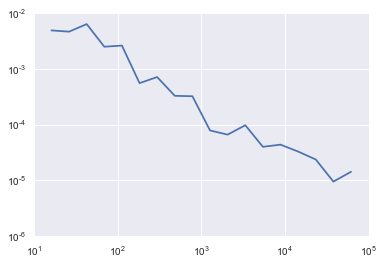

In [94]:
a = np.abs(ms.drop("n_steps", axis=1).sub(rates, axis=1)).mean(axis=1).values
plt.loglog(N_STEPS[1:-1], a[1:-1])

# Sensitivity of off-diagonal elements to sampling error

In [97]:
channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                  Q=np.linalg.qr(np.random.randn(3,3))[0],
                  n=1e14, d1=D, d2=D, d3=D)
channel.update()

In [3]:
p = 1e-2
D = 0.0001
N_TRIALS = 1000
N_STEPS = np.logspace(2, 8, 40)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    for n_steps in N_STEPS:
        channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                          Q=np.linalg.qr(np.random.randn(3,3))[0],
                          n=n_steps, d1=D, d2=D, d3=D)
        channel.update()
        elterrs = np.abs(np.reshape(channel.C - channel.Ahat, (9,1))[[0, 1, 2, 4, 5, 8]].T[0])
        RECORDS.append({"n": n_steps,
                        "m11_err": elterrs[0],
                        "m22_err": elterrs[3],
                        "m33_err": elterrs[5],
                        "m12_err": elterrs[1],
                        "m13_err": elterrs[2],
                        "m23_err": elterrs[4]})

df = pd.DataFrame(RECORDS)
df.to_csv('mij_errs.csv')

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


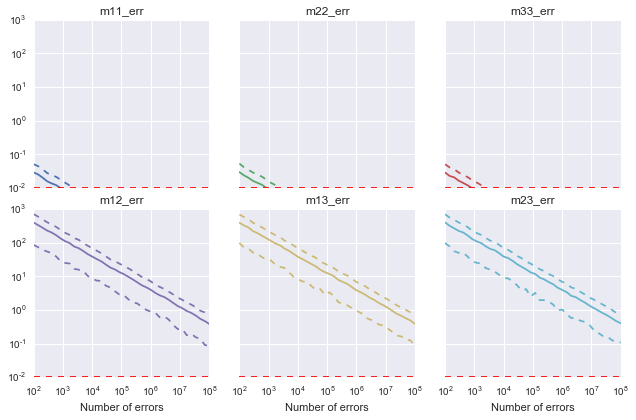

In [4]:
df = df.loc[:, ["m11_err", "m22_err", "m33_err", "m12_err", "m13_err", "m23_err", "n"]]

ms = df.groupby("n").mean()
ss = df.groupby("n").std()
fig, axs = plt.subplots(2, 3, figsize=(9, 6),
                        sharex=True, sharey=True,
                        tight_layout={"h_pad": 0.1})

for k in range(6):
    idx = (int(k/3), k % 3)
    v = ms.iloc[:, k]
    s = ss.iloc[:, k]
    t = ms.index.values
    axs[idx].loglog(t, v, ls="-", c=sns.color_palette()[k])
    axs[idx].loglog(t, v-s, ls="--", c=sns.color_palette()[k])
    axs[idx].loglog(t, v+s, ls="--", c=sns.color_palette()[k])
    axs[idx].axhline(1e-2, ls="--", c="red")
    axs[idx].set_title(ms.columns[k])

axs[1, 0].set_xlabel("Number of errors")
axs[1, 1].set_xlabel("Number of errors")
axs[1, 2].set_xlabel("Number of errors")

In [184]:
L = SENSOR(0.1, 0.1, 0.1)
Linv = np.round(np.dot(np.linalg.inv(np.dot(L.T, L)), L.T), 3)

np.sqrt(np.sum(Linv ** 2, axis=1))

array([ 0.745,  9.116,  9.116,  0.745,  9.116,  0.745])

# How long does it take the linear inversion to converge?

In [291]:
p = 1e-2
D = np.logspace(-2, -4, 10)
N_TRIALS = 1000
N_STEPS = np.logspace(2, 8, 40)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    for d in D:
        for n_steps in N_STEPS:
            channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                              Q=np.linalg.qr(np.random.randn(3,3))[0],
                              n=n_steps, d1=d, d2=d, d3=d)
            channel.update()
            QAhat = np.linalg.svd(channel.Ahat)[0]
            Qhat, phat = np.linalg.svd(channel.Mhat)[0:2]
            maxidx = np.argmax(phat)
            RECORDS.append({"n": n_steps,
                            "d": d,

                            "C_Mhat":     np.linalg.norm(channel.C-channel.Mhat),
                            "Mhat_Ahat":  np.linalg.norm(channel.Ahat-channel.Mhat),
                            "Ahat_M":     np.linalg.norm(channel.C-channel.Ahat),

                            "Q_Qhat":     np.linalg.norm(channel.Q - Qhat),
                            "Qhat_QAhat": np.linalg.norm(Qhat - QAhat),
                            "QAhat_Q":    np.linalg.norm(QAhat - channel.Q),

                            "q_qhat":     np.linalg.norm(channel.Q[maxidx, :] - Qhat[maxidx, :]),
                            "qhat_qahat": np.linalg.norm(Qhat[maxidx, :] - QAhat[maxidx, :]),
                            "qahat_q":    np.linalg.norm(QAhat[maxidx, :] - channel.Q[maxidx, :]),
                            
                            "c11_m11": np.abs(channel.C[0,0] - channel.Mhat[0,0]),
                            "c22_m22": np.abs(channel.C[1,1] - channel.Mhat[1,1]),
                            "c33_m33": np.abs(channel.C[2,2] - channel.Mhat[2,2]),
                            "c12_m12": np.abs(channel.C[0,1] - channel.Mhat[0,1]),
                            "c13_m13": np.abs(channel.C[0,2] - channel.Mhat[0,2]),
                            "c23_m23": np.abs(channel.C[1,2] - channel.Mhat[1,2]),
                            
                            "c11_a11": np.abs(channel.C[0,0] - channel.Ahat[0,0]),
                            "c22_a22": np.abs(channel.C[1,1] - channel.Ahat[1,1]),
                            "c33_a33": np.abs(channel.C[2,2] - channel.Ahat[2,2]),
                            "c12_a12": np.abs(channel.C[0,1] - channel.Ahat[0,1]),
                            "c13_a13": np.abs(channel.C[0,2] - channel.Ahat[0,2]),
                            "c23_a23": np.abs(channel.C[1,2] - channel.Ahat[1,2])
                        })

df = pd.DataFrame(RECORDS)
df.to_csv("varyingD.csv")

In [13]:
df = pd.read_csv("varyingD.csv", index_col=0)
cols = ['d', 'n',
 'Ahat_M',   'C_Mhat', 'Mhat_Ahat',
 'QAhat_Q',  'Q_Qhat', 'Qhat_QAhat',
 'q_qhat',  'qahat_q', 'qhat_qahat',
 'c11_a11', 'c22_a22', 'c33_a33',
 'c12_a12', 'c13_a13', 'c23_a23',
 'c11_m11', 'c22_m22', 'c33_m33',
 'c12_m12', 'c13_m13', 'c23_m23']
df = df[cols]

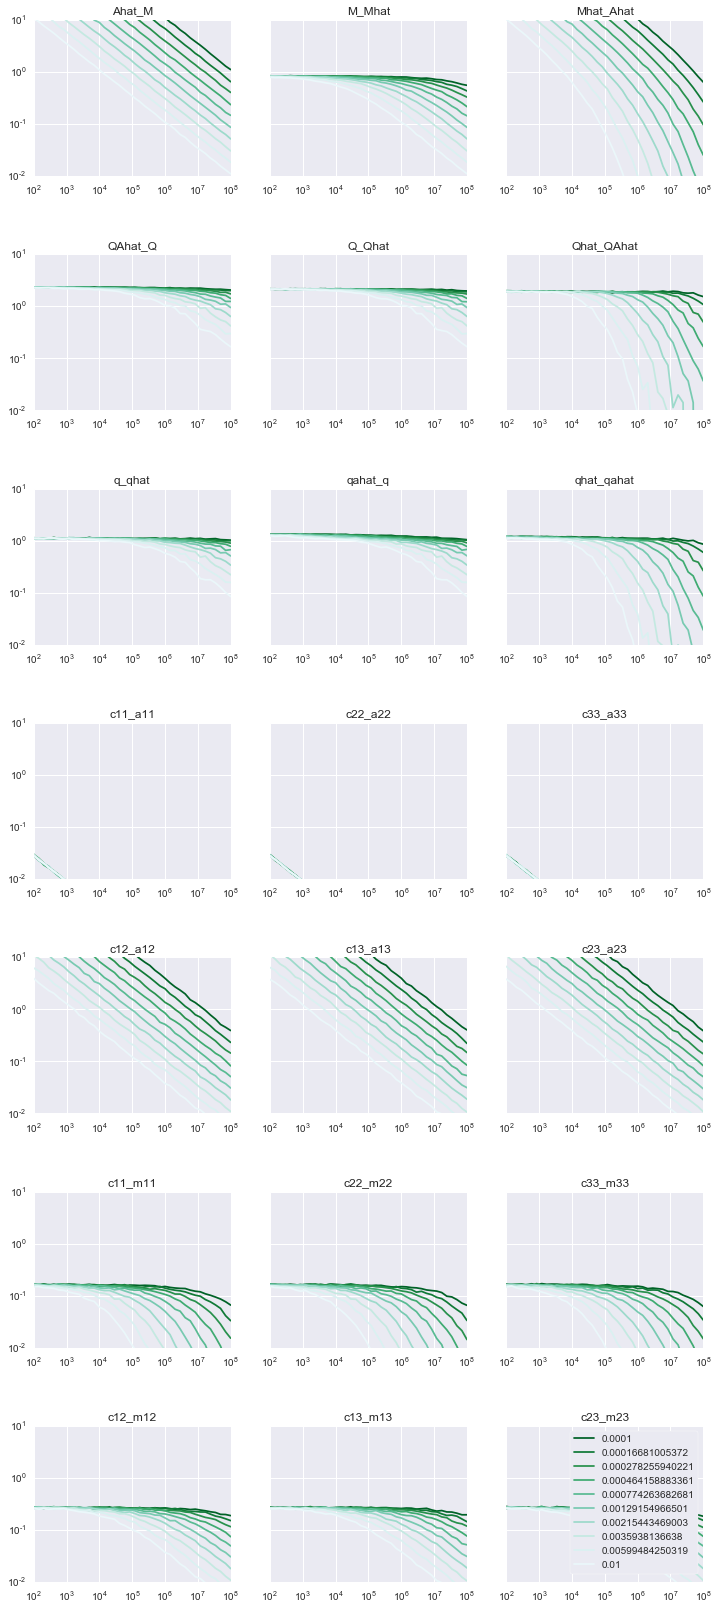

In [17]:
fig, axs = plt.subplots(7, 3, figsize=(12,28),
                        sharey=True)
PAL = sns.color_palette("BuGn_r", len(df["d"].unique()))
axs[0,0].set_ylim([1e-2, 1e1])

for idx, col in enumerate(df.drop(["n","d"], axis=1).columns):
    t = df.pivot_table(index="n", columns="d", values=col)

    for cidx, (d, y) in enumerate(t.iteritems()):
        axs[int(idx/3), idx%3].loglog(y.index.values, y.values,
                        label=str(d),
                        c = PAL[cidx])
    axs[int(idx/3), idx%3].set_title(col)
axs[0, 1].set_title("M_Mhat")
plt.legend(frameon=True)

In [325]:
ds = df.pivot_table(index="n", columns="d", values="Ahat_M")
ds.index = np.log(ds.index)
ds = np.log(ds)

REG = []
for d, data in ds.iteritems():
    reg = sp.stats.linregress(data.index, data.values)
    REG.append({
            "d": d,
            "slope": reg.slope,
            "intercept": np.exp(reg.intercept)
        })

ds = pd.DataFrame(REG)
ds["1.0/d"] = 1.0 / ds["d"]
ds

,d,intercept,slope,1.0/d
0,0.000100,10973.623871,-0.499659,10000.000000
1,0.000167,6637.246319,-0.500034,5994.842503
2,0.000278,3975.074753,-0.500162,3593.813664
3,0.000464,2387.581740,-0.500167,2154.434690
4,0.000774,1416.178449,-0.499520,1291.549665
5,0.001292,847.127579,-0.499222,774.263683
6,0.002154,502.316507,-0.498601,464.158883
7,0.003594,306.146530,-0.499842,278.255940
8,0.005995,185.348663,-0.500448,166.810054
9,0.010000,110.235274,-0.500176,100.000000


So now I can confirm (I guess, "again") that

$$ \| \hat{A} - M \|_2 \sim \frac{1}{\delta} e^{-pt/2} $$

# How does $q - \hat{q}$ scale?

In [355]:
N_TRIALS = 10000
N_STEPS = np.logspace(2, 17, 30)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    for n_steps in N_STEPS:
        channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                          Q=np.linalg.qr(np.random.randn(3,3))[0],
                          n=n_steps, d1=0.01, d2=0.01, d3=0.01)
        channel.update()
        QAhat = np.linalg.svd(channel.Ahat)[0]
        Qhat, phat = np.linalg.svd(channel.Mhat)[0:2]
        maxidx = np.argmax(phat)
        RECORDS.append({"n": n_steps,
                        "d": d,
                        "q_qhat":     np.linalg.norm(channel.Q[maxidx, :] - Qhat[maxidx, :])
                    })

df = pd.DataFrame(RECORDS)
df.to_csv("qqhatscaling.csv")

In [393]:
df = pd.read_csv("qqhatscaling.csv", index_col=0)
ds = df.groupby(["n"]).mean().reset_index()
ds.drop("d", axis=1, inplace=True)
ds = np.log(ds)

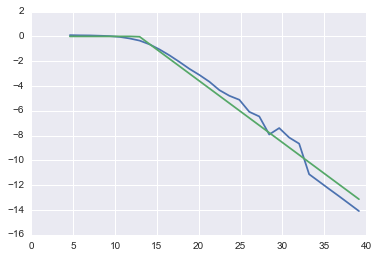

In [407]:
plt.plot(ds["n"], ds["q_qhat"])
y = 2*np.pi/0.01 * np.exp(- ds["n"] / 2.0)
idx = y > 1.0
y[idx] = 1.0
plt.plot(ds["n"], np.log(y))

## Graphing pre-"varying delta"

In [261]:
v = df.groupby("n").mean()
s = df.groupby("n").std()
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True,
                        figsize=(9, 9),
                        tight_layout={'h_pad': 0.1})

axs[0, 0].set_ylim([1e-3, 1e1])
axs[0, 0].loglog(v.index.values, v["C_Mhat"].values, c=sns.color_palette()[0])
axs[0, 0].loglog(v.index.values, v["C_Mhat"].values - s["C_Mhat"].values,
                 ls="--", c=sns.color_palette()[0], alpha=0.25)
axs[0, 0].loglog(v.index.values, v["C_Mhat"].values + s["C_Mhat"].values,
                 ls="--", c=sns.color_palette()[0], alpha=0.25)
axs[0, 0].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[0, 0].set_title("1. $\| M - \hat{M} \|$")

axs[0, 1].loglog(v.index.values, v["Mhat_Ahat"].values, c=sns.color_palette()[1])
axs[0, 1].loglog(v.index.values, v["Mhat_Ahat"].values - s["Mhat_Ahat"].values,
                 ls="--", c=sns.color_palette()[1], alpha=0.25)
axs[0, 1].loglog(v.index.values, v["Mhat_Ahat"].values + s["Mhat_Ahat"].values,
                 ls="--", c=sns.color_palette()[1], alpha=0.25)
axs[0, 1].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[0, 1].set_title("2. $\| \hat{M} - \hat{A} \|$")

axs[0, 2].loglog(v.index.values, v["Ahat_M"].values, c=sns.color_palette()[3])
axs[0, 2].loglog(v.index.values, v["Ahat_M"].values - s["Ahat_M"].values,
                 ls="--", c=sns.color_palette()[3], alpha=0.25)
axs[0, 2].loglog(v.index.values, v["Ahat_M"].values + s["Ahat_M"].values,
                 ls="--", c=sns.color_palette()[3], alpha=0.25)
axs[0, 2].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[0, 2].set_title("3. $\| \hat{A} - M \|$")




axs[1, 0].loglog(v.index.values, v["Q_Qhat"].values, c=sns.color_palette()[0])
axs[1, 0].loglog(v.index.values, v["Q_Qhat"].values - s["Q_Qhat"].values,
                 ls="--", c=sns.color_palette()[0], alpha=0.25)
axs[1, 0].loglog(v.index.values, v["Q_Qhat"].values + s["Q_Qhat"].values,
                 ls="--", c=sns.color_palette()[0], alpha=0.25)
axs[1, 0].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[1, 0].set_title("1. $\| Q - \hat{Q} \|$")

axs[1, 1].loglog(v.index.values, v["Qhat_QAhat"].values, c=sns.color_palette()[1])
axs[1, 1].loglog(v.index.values, v["Qhat_QAhat"].values - s["Qhat_QAhat"].values,
                 ls="--", c=sns.color_palette()[1], alpha=0.25)
axs[1, 1].loglog(v.index.values, v["Qhat_QAhat"].values + s["Qhat_QAhat"].values,
                 ls="--", c=sns.color_palette()[1], alpha=0.25)
axs[1, 1].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[1, 1].set_title("2. $\| \hat{Q} - \hat{Q}_A \|$")

axs[1, 2].loglog(v.index.values, v["QAhat_Q"].values, c=sns.color_palette()[3])
axs[1, 2].loglog(v.index.values, v["QAhat_Q"].values - s["QAhat_Q"].values,
                 ls="--", c=sns.color_palette()[3], alpha=0.25)
axs[1, 2].loglog(v.index.values, v["QAhat_Q"].values + s["QAhat_Q"].values,
                 ls="--", c=sns.color_palette()[3], alpha=0.25)
axs[1, 2].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[1, 2].set_title("3. $\| \hat{Q}_A - Q \|$")




axs[2, 0].loglog(v.index.values, v["q_qhat"].values, c=sns.color_palette()[0])
axs[2, 0].loglog(v.index.values, v["q_qhat"].values - s["q_qhat"].values,
                 ls="--", c=sns.color_palette()[0], alpha=0.25)
axs[2, 0].loglog(v.index.values, v["q_qhat"].values + s["q_qhat"].values,
                 ls="--", c=sns.color_palette()[0], alpha=0.25)
axs[2, 0].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[2, 0].set_title("1. $\| q - \hat{q} \|$")
axs[2, 0].set_xlabel("Number of errors")

axs[2, 1].loglog(v.index.values, v["qhat_qahat"].values, c=sns.color_palette()[1])
axs[2, 1].loglog(v.index.values, v["qhat_qahat"].values - s["qhat_qahat"].values,
                 ls="--", c=sns.color_palette()[1], alpha=0.25)
axs[2, 1].loglog(v.index.values, v["qhat_qahat"].values + s["qhat_qahat"].values,
                 ls="--", c=sns.color_palette()[1], alpha=0.25)
axs[2, 1].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[2, 1].set_title("2. $\| \hat{q} - \hat{q}_A \|$")
axs[2, 1].set_xlabel("Number of errors")

axs[2, 2].loglog(v.index.values, v["qahat_q"].values, c=sns.color_palette()[3])
axs[2, 2].loglog(v.index.values, v["qahat_q"].values - s["qahat_q"].values,
                 ls="--", c=sns.color_palette()[3], alpha=0.25)
axs[2, 2].loglog(v.index.values, v["qahat_q"].values + s["qahat_q"].values,
                 ls="--", c=sns.color_palette()[3], alpha=0.25)
axs[2, 2].axhline(1e-2, ls="--", c=sns.color_palette()[2])
axs[2, 2].set_title("3. $\| \hat{q}_A - q \|$")
axs[2, 2].set_xlabel("Number of errors")

If I wait for 1e3 errors instead of 1e4 and then I realign, how bad is my estimate? Do I stand to gain anything?

Think about the _direction_ of the noise within the components of `data`

## Regime 1 basis alignment

In [ ]:
D = 0.01*np.pi
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d1=D, d2=D, d3=D)
    pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "tr": np.trace(channel.Mhat),
            "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
        channel.d1 = D * np.min([pxhat, pyhat]) / np.sqrt(np.abs(pxhat-pyhat))
        channel.d2 = D * np.min([pxhat, pzhat]) / np.sqrt(np.abs(pxhat-pzhat))
        channel.d3 = D * np.min([pyhat, pzhat]) / np.sqrt(np.abs(pyhat-pzhat))
        RECORDS.append({
                "trial": trial,
                "time": time,
                "tr": np.trace(channel.Mhat),
                "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime1_adaptive_delta.csv")

In [ ]:
D = 0.25*np.pi
N_TRIALS = 100
MAX_N = int(1e6)
N_STEP = int(1e3)
RECORDS = []
for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.985, ky=0.01, kz=0.005,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=N_STEP, d1=D, d2=D, d3=D)
    pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
    RECORDS.append({
            "trial": trial,
            "time": 0,
            "tr": np.trace(channel.Mhat),
            "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
            "Mdist": np.linalg.norm(channel.Mhat-channel.C),
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
            "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
            "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
        })
    for time in range(0, MAX_N, N_STEP):
        channel.update()
        pxhat, pyhat, pzhat = list(np.linalg.eig(channel.Mhat)[0])
        channel.d1 = D * np.min([pxhat, pyhat]) / np.sqrt(np.abs(pxhat-pyhat))
        channel.d2 = D * np.min([pxhat, pzhat]) / np.sqrt(np.abs(pxhat-pzhat))
        channel.d3 = D * np.min([pyhat, pzhat]) / np.sqrt(np.abs(pyhat-pzhat))
        RECORDS.append({
                "trial": trial,
                "time": time,
                "tr": np.trace(channel.Mhat),
                "d1": channel.d1, "d2": channel.d2, "d3": channel.d3,
                "Mdist": np.linalg.norm(channel.Mhat-channel.C),
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3)),
                "pxval": channel.kx, "pyval": channel.ky, "pzval": channel.kz,
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat
            })

df = pd.DataFrame(RECORDS)
df.to_csv("regime2_adaptive_delta.csv")

In [ ]:
df1 = pd.read_csv("regime1_adaptive_delta.csv")
v1 = df1.groupby("time").mean()
s1 = df1.groupby("time").std()

df2 = pd.read_csv("regime2_adaptive_delta.csv")
v2 = df2.groupby("time").mean()
s2 = df2.groupby("time").std()

In [ ]:
v1

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8), sharey=True, sharex=True,
                        tight_layout={"h_pad": 1.0, "rect": [0.0, 0.0, 1.0, 0.95]})

for idx, stat in enumerate(["pxhat", "pyhat", "pzhat"]):
    t1 = v1[stat].index.values
    y1 = v1[stat].values
    e1 = s1[stat].values
    x = np.log(v1.loc[1:, stat].index.values)
    y = np.log(v1.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[0, idx].semilogy(t1, y1, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[0, idx].semilogy(t1, y1+e1, ls="--", color=sns.color_palette()[idx])
    axs[0, idx].semilogy(t1[1:], fitted, ls=":", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[0, idx].axhline(df1.loc[0, stat[:2]+"val"], color=sns.color_palette()[idx])
    axs[0, idx].set_title(stat)
    axs[0, idx].legend(frameon=True)
    
    t2 = v2[stat].index.values
    y2 = v2[stat].values
    e2 = s2[stat].values
    x = np.log(v2.loc[1:, stat].index.values)
    y = np.log(v2.loc[1:, stat].values)
    reg = sp.stats.linregress(x, y)
    fitted = np.exp(reg.intercept + reg.slope * x)
    axs[1, idx].semilogy(t2, y2, ls="", marker=".", color=sns.color_palette()[idx], alpha=0.05)
    axs[1, idx].semilogy(t2, y2+e2, ls="--", color=sns.color_palette()[idx])
    axs[1, idx].semilogy(t2[1:], fitted, ls=":", color=sns.color_palette()[idx],
                         label="{} = {:0.2f} e^({:0.2f}*n)".format(stat, np.exp(reg.intercept), reg.slope))
    axs[1, idx].axhline(df2.loc[0, stat[:2]+"val"], color=sns.color_palette()[idx])
    axs[1, idx].set_xlabel("Number of errors")
    axs[1, idx].legend(frameon=True)

fig.suptitle("Average difference in effective error probability (steps are 1e3, max is 1e6)")
axs[0, 0].set_ylabel("kx=0.7, ky=0.2, kz=0.1")
axs[1, 0].set_ylabel("kx=0.985, ky=0.01, kz=0.005")

axs[0, 3].semilogy(v1["d"].index.values, v1["d"].values, color=sns.color_palette()[3])
axs[1, 3].semilogy(v2["d"].index.values, v2["d"].values, color=sns.color_palette()[3])

axs[1, 0].set_ylim([0.001, 1.0])
axs[0, 0].set_ylim([0.001, 1.0])
fig.savefig("adaptivedelta_1e3_1e6.pdf")